In [22]:
import torch as th
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from models import DINCAE_pconvs
from preprocessing.dataset_normalization_v2 import MinMaxNormalization

In [31]:
result_idx = 50
dataset_idx = 0

data_path = Path("../data/")
dataset_path = data_path / Path(f"minimal_datasets/dataset_{dataset_idx}.pt")
weights_path = data_path / Path(f"weights/weights_{result_idx}.pt")
# weights_path = data_path / Path(f"weights_to_sync/weights_{result_idx}.pt")
nans_masks_path = data_path / Path(f"nans_masks/nans_mask_{dataset_idx}.pt")
minmax_path = data_path / Path(f"minmax_vals/minmax_{dataset_idx}.pt")

for path in [dataset_path, weights_path, nans_masks_path, minmax_path]:
    if not path.exists():
        raise FileNotFoundError(f"Path {path} does not exist.")

dataset = th.load(dataset_path)
weights = th.load(weights_path)
nans_masks = th.load(nans_masks_path)
minmax = th.load(minmax_path)

In [32]:
# Retieve dataset specs
n_channels = 5
nrows = 128
ncols = 128
n_images = 200
masked_channels = [0, 1]

In [33]:
model = DINCAE_pconvs(params_path=Path("params.json"))

model.load_state_dict(weights)

<All keys matched successfully>

Random index: [14]


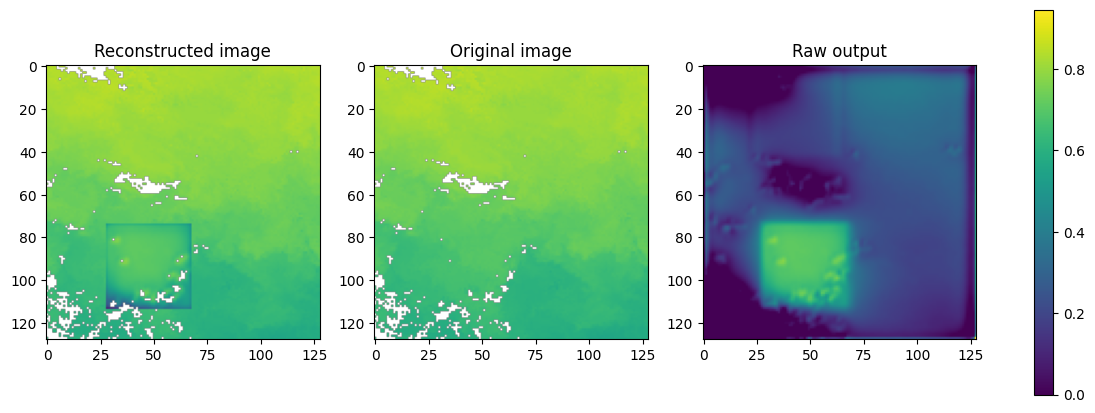

In [34]:
# Get random image
# random_index = np.random.choice(n_images, 1, replace=False)

random_index = [14]

print(f"Random index: {random_index}")

image = dataset["images"][random_index]
mask = dataset["masks"][random_index]
nans_mask = nans_masks[random_index]

if model.__class__.__name__ == "DINCAE_pconvs":
    output, _ = model(image, mask)
else:
    output = model(th.where(mask == 0, image, -1))

raw_output = output.clone()

image = th.where(nans_mask == 0, th.nan, image)

output = th.where(mask == 0, output, image) # Where mask is 0, use the output, else use the original image
output = th.where(nans_mask == 0, th.nan, output)
np_output = output.detach().squeeze().numpy()
np_image = image.detach().squeeze().numpy()

mask = mask.detach().squeeze().numpy()
nans_mask = nans_mask.detach().squeeze().numpy()

# Determine global vmin and vmax to ensure same colormap scaling
vmin = np.nanmin([np_output, np_image])
vmax = np.nanmax([np_output, np_image])

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

channel = 0
im0 = axs[0].imshow(np_output[channel, :, :], vmin=vmin, vmax=vmax)
axs[0].set_title("Reconstructed image")


im1 = axs[1].imshow(np_image[channel, :, :], vmin=vmin, vmax=vmax)
axs[1].set_title("Original image")

im2 = axs[2].imshow(raw_output[0, channel, :, :].detach().numpy(), vmin=vmin, vmax=vmax)
axs[2].set_title("Raw output")

# Shared colorbar using one of the images
fig.colorbar(im1, ax=axs, orientation='vertical')

plt.show()

In [35]:
norm_class = MinMaxNormalization()
denormalized_raw_output = norm_class.denormalize(raw_output, minmax).detach().numpy()
denormalized_image = norm_class.denormalize(image, minmax).detach().numpy()
denormalized_output = norm_class.denormalize(output, minmax).detach().numpy()


Reconstructed image min: 276.043212890625, max: 300.8900146484375


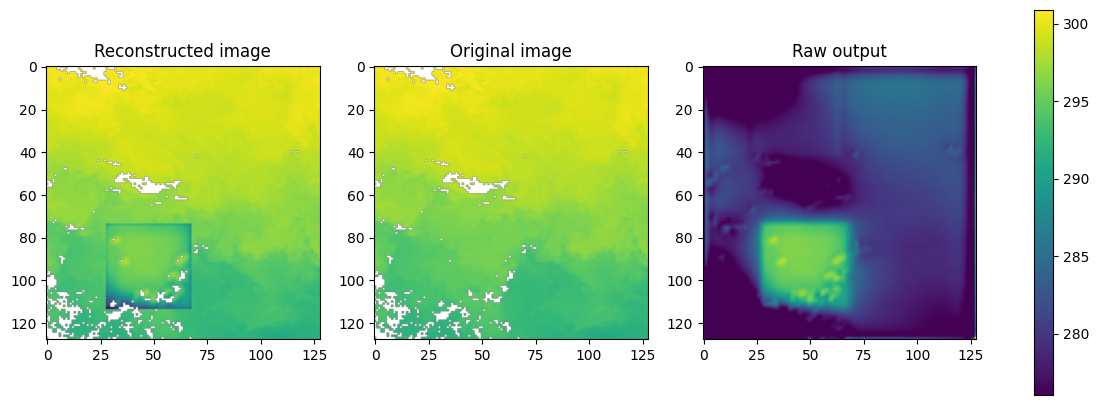

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
channel = 0

vmin = np.nanmin([denormalized_output[0, channel, :, :], denormalized_image[0, channel, :, :]])
vmax = np.nanmax([denormalized_output[0, channel, :, :], denormalized_image[0, channel, :, :]])
print(f"Reconstructed image min: {vmin}, max: {vmax}")
im0 = axs[0].imshow(denormalized_output[0, channel, :, :], vmin=vmin, vmax=vmax)
axs[0].set_title("Reconstructed image")
im1 = axs[1].imshow(denormalized_image[0, channel, :, :], vmin=vmin, vmax=vmax)
axs[1].set_title("Original image")
im2 = axs[2].imshow(denormalized_raw_output[0, channel, :, :], vmin=vmin, vmax=vmax)
axs[2].set_title("Raw output")

fig.colorbar(im1, ax=axs, orientation='vertical')
plt.show()
